# Reading 1D ecRad Output File

Version 5: 2023-07-07

Fixed parameters:
1. Cosine of solar zenith angle $\mu = .6$ (effective solar zenith angle of $53^{\circ}$, Wallace&Hobbs, 2006)
2. SW albedo $\alpha = .05$ (Hartmann & Berry, 2017).
3. LW emissivity $\epsilon = .97$ (REFERENCE?)
4. Skin temperature as surface temperature $T_{skin}$ of 290 to 300 K (Jin & Dickinson, 2010, https://iopscience.iop.org/article/10.1088/1748-9326/5/4/044004/pdf)
5. No gases and aerosols.
6. No liquid water.
7. Tropical sounding (Lapse Rate of $6.7\;K/km$ (see on next cells below)).

Variable parameters:
1. Ice Water Path (IWP) = 30 $g/m^2$ (Sokol & Hartmann 2020):

    $$IWP \;=\; \int{IWC\;dz} \;=\; \int_{h_1}^{h_2}{q_i\;\rho(z)\;dz}\;\;\; , \;\;\;(h_2 - h_1 = 1.5 \;km)$$

    where IWC is the Ice Water Content $(g/m^3)$, which is the Ice Water Mixing Ratio $q_{i}\;(g/km)$ times the density $\rho(z)$:

    $$\Rightarrow\;q_i = IWP{\int_{h_1}^{h_2}{\rho(z)\;dz}}$$
2. Effective Radius $r_e$ = 1 to 100 $\mu m$ every 5 (1, 5, 10, 15...) (REFERENCE?).

## Loading Libraries

Version list:

1. xarray : 2022.11.0
2. numpy : 1.23.4
4. matplotlib : 3.6.2

In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt

%matplotlib notebook

## Reading data

### ecRad output data

- 1O: Fu
- 2O: Baran2016
- 3O: Yi

In [2]:
data_path = ('/groups/sylvia/ecrad_tests/ecrad_test_1/')
for pert in ['236','218','201']:
    for opt in range(1,4):
        globals()['ecrad_out_'+pert+'_'+str(opt)+'O1S'] = xr.open_dataset(data_path+'output_1D_matrix_re_'+pert+'_'+str(opt)+'O1S_v5.nc')

### Tropical Profile

In [3]:
tropical_profile = pd.read_csv('/home/u5/edgardo/p01_crh_sensitivity/tropical_profile_ellingson_250m.txt',
                               sep='\s+ ')

/tmp/ipykernel_48719/1624852093.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tropical_profile = pd.read_csv('/home/u5/edgardo/p01_crh_sensitivity/tropical_profile_ellingson_250m.txt',


In [4]:
temp_int       = interpolate.interp1d(tropical_profile['pressure (hPa)'].iloc[::-1]*100,
                                      tropical_profile['temperature (K)'].iloc[::-1])
temperature_hl = temp_int(ecrad_out_236_1O1S.pressure_hl.values)

### Cloud Heating Rate (CRH) matrix calculation:

In [5]:
rows_re = ecrad_out_236_1O1S.sizes['column']     # Effective Radius (5 - 100 um)
prof    = ecrad_out_236_1O1S.sizes['half_level'] # Vertical Profile

## Heat capacity [J kg^-1 K^-1]:
cp = 1.08*10**(3)
## Volumetric heat capacity as ICON evaluates on model levels, not pl:
# cv = 0.718*10**3
## Gravity [m s^-2]:
g = 9.8

for pert in ['236','218','201']:
    ## Heating rates matrices [K day-1]:
    globals()['H_lw_'+pert] = np.zeros((3, rows_re, prof-1))
    globals()['H_sw_'+pert] = np.zeros((3, rows_re, prof-1))
    globals()['H_'+pert]    = np.zeros((3, rows_re, prof-1))

    ## Matrices for plotting:
    globals()['H_sw_'+pert+'_plot'] = np.zeros((3, prof-1, rows_re))
    globals()['H_lw_'+pert+'_plot'] = np.zeros((3, prof-1, rows_re))
    globals()['H_'+pert+'_plot']    = np.zeros((3, prof-1, rows_re))

    for opt in range(1,4): # per optical scheme
        ecrad_out = eval('ecrad_out_'+pert+'_'+str(opt)+'O1S')
        for i in range(rows_re):
            pres = ecrad_out.pressure_hl.values[i] # Pressure [Pa]

            # Net Fluxes [W m-2]
            lw_net_flux_cloudy = ecrad_out.flux_dn_lw.values[i] - ecrad_out.flux_up_lw.values[i]
            lw_net_flux_clear  = ecrad_out.flux_dn_lw_clear.values[i] - ecrad_out.flux_up_lw_clear.values[i]
            sw_net_flux_cloudy = ecrad_out.flux_dn_sw.values[i] - ecrad_out.flux_up_sw.values[i]
            sw_net_flux_clear  = ecrad_out.flux_dn_sw_clear.values[i] - ecrad_out.flux_up_sw_clear.values[i]

            # Cloud Radiative Effect [W m-2]
            lw_cre = lw_net_flux_cloudy - lw_net_flux_clear
            sw_cre = sw_net_flux_cloudy - sw_net_flux_clear

            # rad = pd.DataFrame({'pressure_hPa':pres*0.01,'lw_cre_Wm2':lw_cre,'sw_cre_Wm2':sw_cre})
            # rad = rad.set_index('pressure_hPa')
            eval('H_lw_'+pert)[opt-1,i,:] = -(g/cp)*(np.diff(lw_cre)/np.diff(pres))*86400 # K day^(-1)
            eval('H_sw_'+pert)[opt-1,i,:] = -(g/cp)*(np.diff(sw_cre)/np.diff(pres))*86400 # K day^(-1)

        eval('H_'+pert)[opt-1,:,:] = eval('H_lw_'+pert)[opt-1,:,:] + eval('H_sw_'+pert)[opt-1,:,:]

        # For plotting:
        eval('H_sw_'+pert+'_plot')[opt-1,:,:] = np.transpose(eval('H_sw_'+pert)[opt-1,:,:])
        eval('H_lw_'+pert+'_plot')[opt-1,:,:] = np.transpose(eval('H_lw_'+pert)[opt-1,:,:])
        eval('H_'+pert+'_plot')[opt-1,:,:]    = np.transpose(eval('H_'+pert)[opt-1,:,:])

#### Cloud Heating Rate (CRH) matrix for plotting (3 perturbations together):

$r_e$ of 1 $\mu m$ is deleted from the matrix, due to Fu error.

In [6]:
temp            = pd.Series(temperature_hl[0])
tropopause_i    = temp.argmin()
upper_limit_i   = (temp.iloc[tropopause_i:] - 201).abs().argmin()
lower_limit_i   = (temp.iloc[tropopause_i:] - 236).abs().argmin()
temp_range      = temp.iloc[tropopause_i+upper_limit_i:tropopause_i+lower_limit_i+1]
melting_layer_i = (temp - 273.15).abs().argmin()
melting_layer   = temp.iloc[melting_layer_i]
tropopause      = temp.min()

In [7]:
## New Matrices for plotting:
H_sw_plot = np.zeros((3, prof-1, rows_re-1))
H_lw_plot = np.zeros((3, prof-1, rows_re-1))
H_plot    = np.zeros((3, prof-1, rows_re-1))

for pert in [236,218,201]:
    pert_i = (temp.iloc[tropopause_i:] - pert).abs().argmin()
    i = tropopause_i + pert_i
    H_sw_plot[:,i-4:i+4,:] = eval('H_sw_'+str(pert)+'_plot')[:,i-4:i+4,1:]
    H_lw_plot[:,i-4:i+4,:] = eval('H_lw_'+str(pert)+'_plot')[:,i-4:i+4,1:]
    H_plot[:,i-4:i+4,:] = eval('H_'+str(pert)+'_plot')[:,i-4:i+4,1:]

#### Evaluating maximum values of CRH

In [8]:
print('Fu max LW: ',H_lw_plot[0,:,1:].max())
print('Fu min LW: ',H_lw_plot[0,:,1:].min())
print('Yi max LW: ',H_lw_plot[2].max())
print('Yi min LW: ',H_lw_plot[2].min())
print('Baran max LW: ',H_lw_plot[1].max())
print('Baran min LW: ',H_lw_plot[1].min())
print()
print('Fu max SW: ',H_sw_plot[0,:,1:].max())
print('Fu min SW: ',H_sw_plot[0,:,1:].min())
print('Yi max SW: ',H_sw_plot[2].max())
print('Yi min SW: ',H_sw_plot[2].min())
print('Baran max SW: ',H_sw_plot[1].max())
print('Baran min SW: ',H_sw_plot[1].min())

Fu max LW:  108.77819921662012
Fu min LW:  -32.14925027062109
Yi max LW:  131.3450574600575
Yi min LW:  -41.48267323823694
Baran max LW:  75.62433050631692
Baran min LW:  -17.7233541912251

Fu max SW:  23.957123194578394
Fu min SW:  -0.8052107385966504
Yi max SW:  25.556829056436925
Yi min SW:  -0.9000063866745287
Baran max SW:  15.131684029383143
Baran min SW:  -0.402134907877294


#### Plotting CRH Matrix

<IPython.core.display.Javascript object>


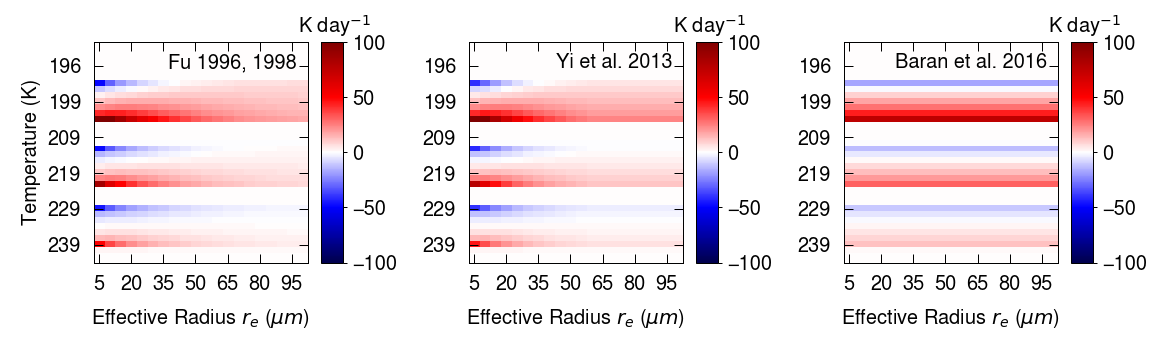

In [9]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
length   = 13 # inches
heigth   = length*.3 # inches

rows    = 1
columns = 3
f, ax   = plt.subplots(rows, columns, figsize=(length, heigth), dpi=72)
plt.subplots_adjust(top = 0.88, bottom = 0.25, left = 0.08, right = 0.95, 
                    hspace = .2, wspace = .4)

# COLORMAPS
for j in [0,2,1]: # Reorganized as Fu, Yi and Baran.
    ji = [0,2,1].index(j)
    # Longwave Heating Rate
    im = ax[ji].imshow(H_lw_plot[j], cmap = "seismic", aspect = 'auto', 
                      vmin = -100, vmax = 100)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
    cbar.set_label(r'K day$^{-1}$', labelpad = -50, y = 1.13, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    cbar.ax.locator_params(nbins=5)

# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0,H_236.shape[2]+3,6) # altitude tick labels
yticklabels = temp.loc[yticks].astype('int').to_list()    
    
# X Axis:
re          = np.arange(5,105,5)
#re          = np.insert(re, 0, 1)
xticks      = np.arange(0,21,3)
xticklabels = re[xticks]#.astype('int').to_list()  

OptSch = ['Fu 1996, 1998', 'Yi et al. 2013', 'Baran et al. 2016']
for j in [0,2,1]: # Reorganized as Fu, Yi and Baran.
    # Horizontal Lines:
    #h = ax[j,i].axhline(y = melting_layer_i, linestyle = 'dashed', color = 'grey',
    #                    dashes = (3, 2), linewidth  =2)
    #h = ax[j,i].axhline(y = tropopause_i, linestyle = 'dashed', color = 'grey',
    #                    dashes = (3, 2), linewidth  =2)
    ax[j].set_xlabel(r'Effective Radius $r_e$ ($\mu m$)',
                     fontsize = fontsize, fontname = fontname,
                     color ='black', labelpad = 10)
    ax[j].tick_params(axis = 'x', which = 'major', color = 'black',
                      size = 7, direction = 'in', top = True,
                      labelsize = fontsize, pad = 10)
    for tick in ax[j].get_xticklabels():
        tick.set_fontname(fontname)
    ax[j].set_xticks(xticks)
    ax[j].set_xticklabels(xticklabels)

    ax[j].tick_params(axis = 'y', which = 'major', color = 'black',
                      size = 7, direction = 'in', right = True,
                      labelsize = fontsize, pad = 10)
    for tick in ax[j].get_yticklabels():
        tick.set_fontname(fontname)
    ax[j].set_yticks(yticks)
    ax[j].set_yticklabels(yticklabels)
    if j == 0:
        ax[j].set_ylabel('Temperature (K)', fontsize = fontsize, fontname = fontname,
                         color ='black', labelpad = 5)
    ax[j].text(0.95, 0.95, OptSch[j],
               ha = 'right', va = 'top', transform = ax[j].transAxes,
               fontsize = fontsize, fontname = fontname, color = 'black')
    ax[j].set_ylim((temp - 245).abs().argmin(), (temp - 200).abs().argmin())


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
plt.savefig(out_dir+'1D_matrix_re_1S_v5.png', dpi = 500)

#### Plotting Difference Matrix

In [10]:
H_sw_diff_plot = np.zeros((2, prof-1, rows_re-1))
H_sw_diff_plot[0] = H_sw_plot[2] - H_sw_plot[0] # Yi - Fu
H_sw_diff_plot[1] = H_sw_plot[1] - H_sw_plot[0] # Baran - Fu

H_lw_diff_plot = np.zeros((2, prof-1, rows_re-1))
H_lw_diff_plot[0] = H_lw_plot[2] - H_lw_plot[0] # Yi - Fu
H_lw_diff_plot[1] = H_lw_plot[1] - H_lw_plot[0] # Baran - Fu

H_diff_plot = np.zeros((2, prof-1, rows_re-1))
H_diff_plot[0] = H_plot[2] - H_plot[0] # Yi - Fu
H_diff_plot[1] = H_plot[1] - H_plot[0] # Baran - Fu

In [11]:
print('Baran - Fu max LW: ',H_lw_diff_plot[1].max())
print('Baran - Fu min LW: ',H_lw_diff_plot[1].min())
print('Yi - Fu max LW: ',H_lw_diff_plot[0].max())
print('Yi - Fu min LW: ',H_lw_diff_plot[0].min())

print('Baran - Fu max SW: ',H_sw_diff_plot[1].max())
print('Baran - Fu min SW: ',H_sw_diff_plot[1].min())
print('Yi - Fu max SW: ',H_sw_diff_plot[0].max())
print('Yi - Fu min SW: ',H_sw_diff_plot[0].min())

Baran - Fu max LW:  58.64986101343078
Baran - Fu min LW:  -69.48719911460292
Yi - Fu max LW:  7.4663120349382694
Yi - Fu min LW:  -13.76647216086235
Baran - Fu max SW:  8.363559902752959
Baran - Fu min SW:  -16.91118801935712
Yi - Fu max SW:  0.3031210534444435
Yi - Fu min SW:  -6.486042992303339


<IPython.core.display.Javascript object>


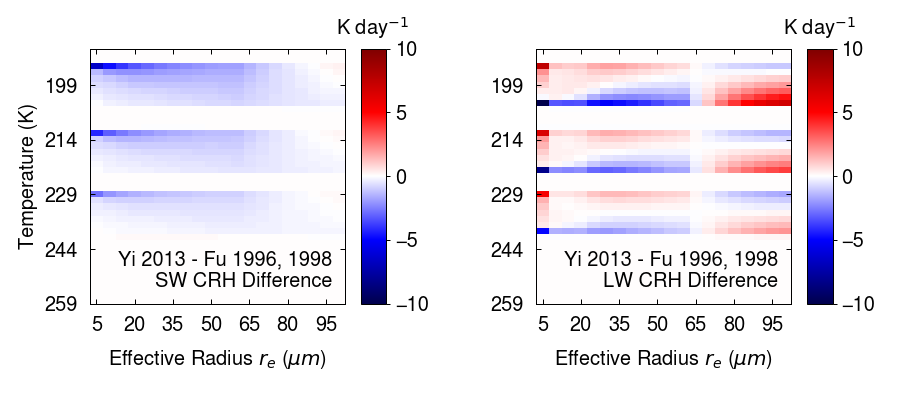

In [13]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
length   = 10 # inches
heigth   = length*.45 # inches

rows = 1
columns = 2
f, ax = plt.subplots(rows, columns, figsize=(length, heigth), dpi=72)
plt.subplots_adjust(top = 0.88, bottom = 0.25, left = 0.1, right = 0.95, 
                    hspace = .2, wspace = .4)

# COLORMAPS
# Shortwave Heating Rate Difference
im = ax[0].imshow(H_sw_diff_plot[0], cmap = "seismic", aspect = 'auto', 
                  vmin = -10, vmax = 10)
cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
cbar.set_label(r'K day$^{-1}$', labelpad = -45, y = 1.13, rotation=0, 
               fontsize = fontsize, fontname = fontname)
cbar.ax.tick_params(labelsize = fontsize)
for tick in cbar.ax.get_yticklabels():
    tick.set_fontname(fontname)
cbar.ax.locator_params(nbins = 5)

# Longwave Heating Rate Difference
im = ax[1].imshow(H_lw_diff_plot[0], cmap = "seismic", aspect = 'auto', 
                  vmin = -10, vmax = 10)
cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
cbar.set_label(r'K day$^{-1}$', labelpad = -45, y = 1.13, rotation=0, 
               fontsize = fontsize, fontname = fontname)
cbar.ax.tick_params(labelsize = fontsize)
for tick in cbar.ax.get_yticklabels():
    tick.set_fontname(fontname)
cbar.ax.locator_params(nbins = 5)


# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0,H_236.shape[2]+9,9) # altitude tick labels
yticklabels = temp.loc[yticks].astype('int').to_list()    
    
# X Axis:
re          = np.arange(5,105,5)
#re          = np.insert(re, 0, 1)
xticks      = np.arange(0,21,3)
xticklabels = re[xticks]#.astype('int').to_list()  

band = ['SW CRH Difference','LW CRH Difference']
for j in range(2): # Reorganized as SW and LW
    ax[j].set_xlabel(r'Effective Radius $r_e$ ($\mu m$)', 
                     fontsize = fontsize, fontname = fontname,
                     color ='black', labelpad = 10)
    ax[j].tick_params(axis = 'x', which = 'major', color = 'black',
                      size = 4, direction = 'in', top = True,
                      labelsize = fontsize, pad = 10)
    for tick in ax[j].get_xticklabels():
        tick.set_fontname(fontname)
    ax[j].set_xticks(xticks)
    ax[j].set_xticklabels(xticklabels) #[::-1]
    ax[j].tick_params(axis = 'y', which = 'major', color = 'black',
                      size = 4, direction = 'in', right = True,
                      labelsize = fontsize, pad = 10)
    for tick in ax[j].get_yticklabels():
        tick.set_fontname(fontname)
    ax[j].set_yticks(yticks)
    ax[j].set_yticklabels(yticklabels)
    if j == 0:
        ax[j].set_ylabel('Temperature (K)', fontsize = fontsize, fontname = fontname,
                         color ='black', labelpad = 5)
    ax[j].text(0.95, 0.05, 'Yi 2013 - Fu 1996, 1998'+'\n'+band[j],
               ha = 'right', va = 'bottom', transform = ax[j].transAxes,
               fontsize = fontsize, fontname = fontname, color = 'black')
    ax[j].set_ylim((temp - 260).abs().argmin(), (tropopause_i-2)+(temp[tropopause_i:] - 196).abs().argmin())


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
plt.savefig(out_dir+'1D_matrix_re_diff_1S_v5.png', dpi=500)

#### Plotting CRH vs $r_e$ for top and bottom level

In [ ]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
length   = 13 # inches
heigth   = length*.9 # inches

my_colors = [(88/255, 148/255, 197/255), (169/255, 23/255, 38/255),
             (229/255, 179/255, 69/255), (131/255, 170/255, 69/255),
             (116/255, 24/255, 123/255), (202/255, 91/255, 46/255),
             (107/255, 188/255, 233/255), 'grey']

rows = 2
columns = 2
f, ax = plt.subplots(rows, columns, figsize=(length,heigth), dpi=72)
plt.subplots_adjust(top = 0.95, bottom = 0.16, left = 0.08, right = 0.95, 
                    hspace = .2, wspace = .2)


# Frame 1x1: SW - Top layer
# Frame 1x2: LW - Top Layer
# Frame 2x1: SW - Bottom Layer
# Frame 2x2: LW - Bottom Layer
# linestyle per temperature. Color per Scheme.
re       = np.arange(5,105,5)
OptSch   = ['Fu, Yang & Sun, 1998', 'Baran et al., 2016', 'Yi et al., 2013']
linestye = ['solid', 'dashed', 'dotted']
handles  = []
labels   = []
for pert in [236,218,201]:
    perti = (temp.iloc[tropopause_i:] - pert).abs().argmin()
    for sch in range(3):
        h = ax[0,0].plot(re, H_sw_plot[sch, tropopause_i+perti-2, :],
                         linestyle = linestye[[236,218,201].index(pert)], 
                         linewidth = 3, color = my_colors[sch], alpha = 1)
        handles = handles + h
        labels.append(str(pert)+' K - '+OptSch[sch])
        h2 = ax[0,1].plot(re, H_lw_plot[sch, tropopause_i+perti-2, :],
                          linestyle = linestye[[236,218,201].index(pert)], 
                          linewidth = 3, color = my_colors[sch], alpha = 1)
        h3 = ax[1,0].plot(re, H_sw_plot[sch, tropopause_i+perti+3, :],
                          linestyle = linestye[[236,218,201].index(pert)], 
                          linewidth = 3, color = my_colors[sch], alpha = 1)
        h3 = ax[1,1].plot(re, H_lw_plot[sch, tropopause_i+perti+3, :],
                          linestyle = linestye[[236,218,201].index(pert)], 
                          linewidth = 3, color = my_colors[sch], alpha = 1)

#ax.grid('on', linestyle = 'dashed', color = 'grey', alpha = .4,
#        dashes = (8, 8), linewidth = .8)

# AXIS PARAMETERS
#X Axis
ax[1,0].set_xlabel(r'Effective Radius $r_e$ ($\mu m$)', fontname = fontname, 
                   fontsize = fontsize, color = 'black', labelpad = 5)
ax[1,1].set_xlabel(r'Effective Radius $r_e$ ($\mu m$)', fontname = fontname, 
                   fontsize = fontsize, color = 'black', labelpad = 5)
for i in range(2):
    for j in range(2):
        #major_ticks_x = np.arange(-60, 60, 10)
        #minor_ticks_x = np.arange(-60, 60, 5)
        #ax.set_xticks(major_ticks_x)
        #ax.set_xticks(minor_ticks_x, minor=True)
        #ax.set_xlim(-50, 50)
        ax[i,j].tick_params(axis = 'x', which = 'major', color = 'black',
                            size = 7, direction = 'in', top = True,
                            labelsize = fontsize, pad=10)
        ax[i,j].tick_params(axis = 'x', which = 'minor',
                            color = 'black', size = 4,
                            direction = 'in', top = True)
        for tick in ax[i,j].get_xticklabels():
            tick.set_fontname(fontname)
    
#Y Axis
ax[0,0].set_ylabel('CHR (K day$^{-1}$)', fontname = fontname, fontsize = fontsize,
                   color = 'black', labelpad = 5)
ax[1,0].set_ylabel('CHR (K day$^{-1}$)', fontname = fontname, fontsize = fontsize,
                   color = 'black', labelpad = 5)

for i in range(2):
    for j in range(2):
        ax[i,j].tick_params(axis = 'y', which = 'major', color = 'black',
               size = 7, direction = 'in', right = True,
               labelsize = fontsize, pad = 10)
        ax[i,j].tick_params(axis = 'y', which = 'minor', color = 'black',
               size = 4, direction = 'in', right = True)
        for tick in ax[i,j].get_yticklabels():
            tick.set_fontname(fontname)

# Additional Texts:
ax[0,0].text(0.95, 0.95, 'Top layer'+'\n'+'Shortwave Heating Rate',
             ha = 'right', va = 'top', transform = ax[0,0].transAxes,
             fontname = fontname, fontsize = fontsize, color = 'black')
ax[0,1].text(0.95, 0.05, 'Top layer'+'\n'+'Longwave Heating Rate',
             ha = 'right', va = 'bottom', transform = ax[0,1].transAxes,
             fontname = fontname, fontsize = fontsize, color = 'black')
ax[1,0].text(0.95, 0.05, 'Bottom layer'+'\n'+'Longwave Heating Rate',
             ha = 'right', va = 'bottom', transform = ax[1,0].transAxes,
             fontname = fontname, fontsize = fontsize, color = 'black')
ax[1,1].text(0.95, 0.95, 'Bottom layer'+'\n'+'Longwave Heating Rate',
             ha = 'right', va = 'top', transform = ax[1,1].transAxes,
             fontname = fontname, fontsize = fontsize, color = 'black')

# Legend:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
legend  = plt.legend(handles, labels, loc = 'lower center',
                     bbox_to_anchor = (.5, .01),
                     bbox_transform = f.transFigure,
                     frameon = False, ncol = 3, columnspacing = 2,
                     labelspacing = .2, labelcolor = 'linecolor',
                     handlelength = 2, handletextpad = 1,
                     prop = {'family': fontname, 'size': fontsize})

# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_crh_re_1S_v4.png', dpi=500)